In [1]:
import sys, os
import numpy as np
from scipy.integrate import simps
from scipy.interpolate import griddata

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle

from glow import lenses
from glow import time_domain
from glow import time_domain_c
from glow import freq_domain
from glow import freq_domain_c

#from random_realizations import distribute_centers, Psi_composite_SIS
from lenses_plots_paper import distribute_centers, \
                               create_composite_lens, \
                               Psi_composite_SIS, \
                               plot_Sigma, \
                               compute_It, \
                               plot_It, \
                               plot_Gt, \
                               plot_Fw, \
                               plot_row, \
                               plot_row_custom, \
                               compare_lens

In [2]:
%matplotlib inline

# Varying lens parameters

## SIS: role of y

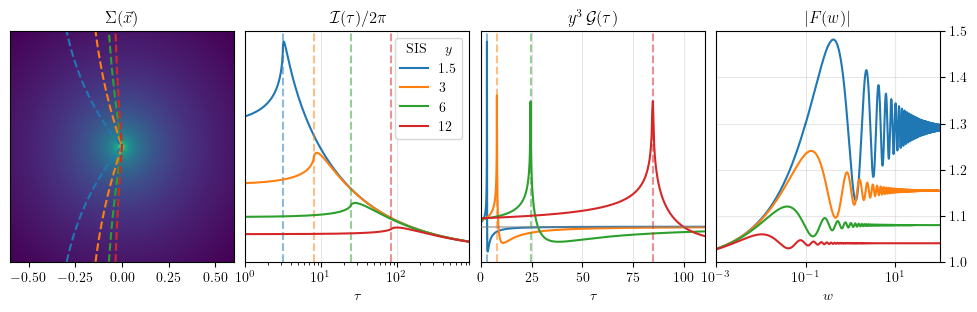

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
plt.subplots_adjust(wspace=0.05)

#plot
Ngrid = 400
eps_soften = 0.1

grid_lim = 0.6
y_plt = 0
eps = eps_soften/Ngrid

p_prec = {'tmin':1e-2, 'tmax':1e6, 'Nt':5000, 'sampling':'log'}
p_prec_w = {'fmin' : 1e-3, \
            'fmax' : 1e2, \
            'interp_kind':'linear', \
            'N_below_discard':3}

#include 
center, width = (max(grid_lim,y_plt*1.1) - grid_lim)/2, (max(grid_lim,y_plt*1.1) + grid_lim)/2
y_grid = np.linspace(-width, width, Ngrid)
x_grid = np.linspace(-width, width, Ngrid) + center

X, Y = np.meshgrid(x_grid,y_grid)

#SIS
R = np.sqrt(X**2 + Y**2)
xc = 0.3
n = 1
Psi_SIS = lenses.Psi_SIS()

dt = 1e-2
deriv = lambda I, t: 0.5*(I.eval_It(t+dt)-I.eval_It(t-dt))/dt

#normalization is ad-hoc
Sigma_SIS = 1/np.sqrt(R**2+eps**2)

## -----------------------------------------------------------------

ax[0].pcolor(X,Y,Sigma_SIS, norm=colors.LogNorm(vmin=Sigma_SIS.min(), vmax=Sigma_SIS.max()),rasterized=True)
ax[0].set_title(r'$\Sigma(\vec x)$')

y_array = [1.5, 3, 6, 12]
for i, y in enumerate(y_array):
    ItSIS = time_domain_c.It_AnalyticSIS_C({'y':y}, p_prec)
    
    Phi0 = Psi_SIS.phi_Fermat(y+1, 0, y)
    PhiC = Psi_SIS.phi_Fermat(0, 0, y) - Phi0
    Phi = Psi_SIS.phi_Fermat(X,Y,y) - Phi0
    
    ax[0].contour(X, Y, Phi,\
                  [Psi_SIS.phi_Fermat(0,0,y)-Phi0],\
                  colors = 'C%i' % i,\
                  linestyles = 'dashed')
    
    tau, It = ItSIS.t_grid, ItSIS.It_grid
    ax[1].plot(tau, It/(2*np.pi), c='C%i' % i, label='%g' % y)
    ax[1].axvline(PhiC, c='C%i' % i, ls='--', alpha=0.5)
    
    G = deriv(ItSIS,tau)
    ax[2].plot(tau, y**3*G, c='C%i' % i)
    ax[2].axvline(PhiC, c='C%i' % i, ls='--', alpha=0.5)
    
    Fw = freq_domain_c.Fw_SL(ItSIS, p_prec=p_prec_w)
    ws = np.geomspace(Fw.w_grid[0], Fw.w_grid[-1], 5000)
    ax[3].semilogx(ws, np.abs(Fw.eval_Fw(ws)), c='C%i' % i)
    
ax[1].legend(title=r'SIS $\quad y$')
ax[1].set_xlabel(r'$\tau$');
ax[1].set_title(r'$\mathcal{I}(\tau)/2\pi$')
ax[1].set_xlim(1,.9e3)
ax[1].set_xscale('log'); #ax[1].set_yscale('log')

ax[2].set_title(r'$y^3\,\mathcal{G}(\tau)$')
ax[2].set_xlabel(r'$\tau$')
ax[2].set_xlim(0,110)
ax[2].axhline(0,c='gray',alpha=0.5,label='0',zorder=10)

ax[3].set_title('$|F(w)|$')
ax[3].set_xlabel('$w$')
ax[3].set_xlim(1e-3,1e2)
ax[3].yaxis.tick_right()
ax[3].set_ylim(1,1.5)

for a in ax[0:3]:
    a.set_yticks([]);
for a in ax[1:4]:
    a.grid(alpha=0.3)
    
fig.savefig('plots/SIS_vary_y_old.pdf',bbox_inches='tight')
#fig.savefig('plots/SIS_vary_y_old.png')

contour plotted
(1/4) y = 1.5  ->  computed  ->  plotted
(2/4) y =   3  ->  computed  ->  plotted
(3/4) y =   6  ->  computed  ->  plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(4/4) y =  12  ->  computed  ->  plotted


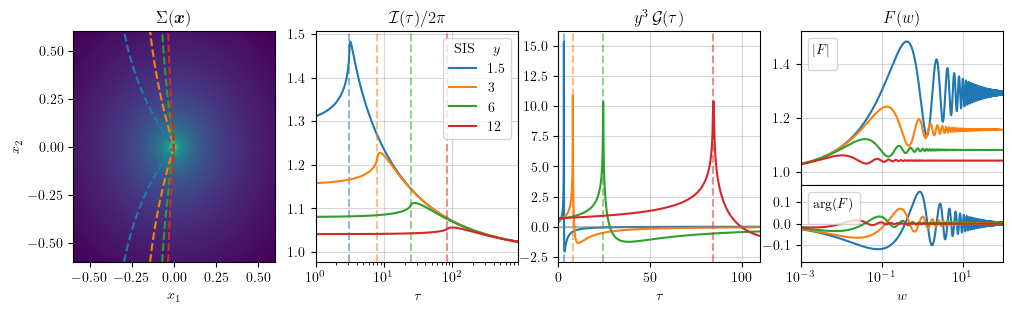

In [4]:
## --- Set up lenses
y_array = [1.5, 3, 6, 12]

p_prec = {'tmin':1e-2, \
          'tmax':1e6, \
          'Nt':5000, \
          'sampling':'log'}

p_prec_w = {'fmin' : 1e-3, \
            'fmax' : 1e2, \
            'interp_kind' : 'linear', \
            'N_above_discard' : 2, \
            'N_below_discard' : 3}

Psi = lenses.Psi_SIS()

dt = 1e-2
deriv = lambda I, t: 0.5*(I.eval_It(t+dt)-I.eval_It(t-dt))/dt

## --- Set up contour
Ngrid = 400
eps_soften = 0.1
grid_lim = 0.6
y_plt = 0
eps = eps_soften/Ngrid

center, width = (max(grid_lim,y_plt*1.1) - grid_lim)/2, (max(grid_lim,y_plt*1.1) + grid_lim)/2
y_grid = np.linspace(-width, width, Ngrid)
x_grid = np.linspace(-width, width, Ngrid) + center

X, Y = np.meshgrid(x_grid,y_grid)
R = np.sqrt(X**2 + Y**2)

Sigma_SIS = 1/np.sqrt(R**2+eps**2)   #normalization is ad-hoc

## --- Set up grid
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0, height_ratios=[2, 1])

ax_S = fig.add_subplot(gs[:, 0])
ax_I = fig.add_subplot(gs[:, 1])
ax_G = fig.add_subplot(gs[:, 2])
ax_F0 = fig.add_subplot(gs[0, 3])
ax_F1 = fig.add_subplot(gs[1, 3])

## --- Compute and plot
ax_S.pcolor(X, Y, Sigma_SIS, norm=colors.LogNorm(vmin=Sigma_SIS.min(), vmax=Sigma_SIS.max()),rasterized=True)
print('contour plotted')

for i, y in enumerate(y_array):
    
    # compute
    It = time_domain_c.It_AnalyticSIS_C({'y':y}, p_prec)
    ts, Its = It.t_grid, It.It_grid
    Gs = deriv(It, ts)
    
    Fw = freq_domain_c.Fw_SL(It, p_prec=p_prec_w)
    ws = np.geomspace(Fw.w_grid[0], Fw.w_grid[-1], 5000)
    Fws = Fw.eval_Fw(ws)
    
    PhiC = Psi.phi_Fermat(0, 0, y) - It.tmin
    Phi = Psi.phi_Fermat(X, Y, y) - It.tmin
    
    print("(%d/%d) y = %3.2g  ->  computed" % (i+1, len(y_array), y), end='')
    
    # plot
    ax_S.contour(X, Y, Phi,\
                 [Psi.phi_Fermat(0, 0, y) - It.tmin],\
                 colors = 'C%i' % i,\
                 linestyles = 'dashed')
    ax_I.plot(ts, Its/(2*np.pi), c='C%i' % i, label='%g' % y)
    ax_I.axvline(PhiC, c='C%i' % i, ls='--', alpha=0.5)
    ax_G.plot(ts, y**3*Gs, c='C%i' % i)
    ax_G.axvline(PhiC, c='C%i' % i, ls='--', alpha=0.5)
    ax_F0.plot(ws, np.abs(Fws), c='C%i' % i)
    ax_F1.plot(ws, np.angle(Fws), c='C%i' % i)
    
    print("  ->  plotted")

ax_S.set_title(r'$\Sigma(\boldsymbol{x})$')
ax_S.set_xlabel('$x_1$')
ax_S.set_ylabel('$x_2$')
ax_S.set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
ax_S.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])

ax_I.set_title(r'$\mathcal{I}(\tau)/2\pi$')
ax_I.legend(title=r'SIS $\quad y$')
ax_I.set_xlabel(r'$\tau$')
ax_I.set_xlim(1,.9e3)
ax_I.set_xscale('log')
ax_I.grid(alpha=0.5)

ax_G.set_title(r'$y^3\,\mathcal{G}(\tau)$')
ax_G.set_xlabel(r'$\tau$')
ax_G.set_xlim(0, 110)
ax_G.axhline(0, c='gray', alpha=0.5, label='0', zorder=10)
ax_G.grid(alpha=0.5)

ax_F0.set_title('$F(w)$')
ax_F0.set_xlim(1e-3, 1e2)
ax_F0.set_ylim(0.95, 1.52)
ax_F0.tick_params(axis='x', labelbottom=False)
ax_F0.set_xscale('log')
ax_F0.grid(alpha=0.5)
ax_F0.legend(title='$|F|$', loc=2)

ax_F1.set_xlabel('$w$')
ax_F1.set_xlim(1e-3, 1e2)
ax_F1.set_ylim(-0.18, 0.18)
ax_F1.set_xscale('log')
ax_F1.grid(alpha=0.5)
ax_F1.legend(title="$\\mathrm{arg}(F)$", loc=2)

fig.savefig('plots/SIS_vary_y.pdf',bbox_inches='tight')
#fig.savefig('plots/SIS_vary_y.png')

## CIS: role of rc

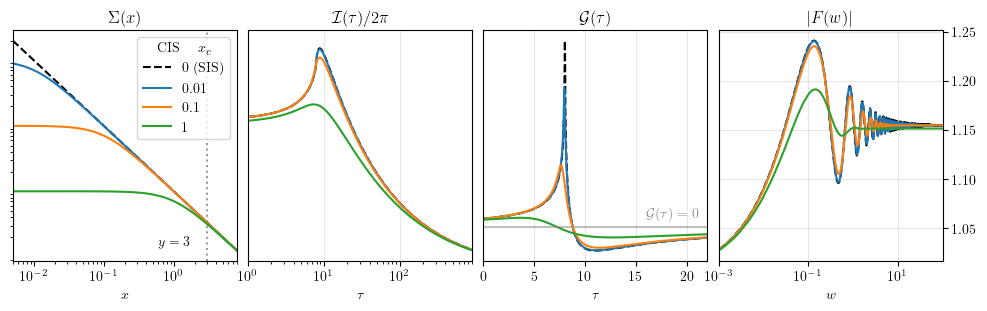

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
plt.subplots_adjust(wspace=0.05)

y = 3
p_phys = {'y' : y}
p_prec = {'tmin':1e-2, 'tmax':1e6, 'Nt':5000, 'sampling':'log'}
p_prec_w = {'fmin' : 1e-3, \
            'fmax' : 1e2, \
            'interp_kind':'linear', \
            'N_below_discard':3}

dt = 1e-2
deriv = lambda I, t: 0.5*(I.eval_It(t+dt)-I.eval_It(t-dt))/dt

ItSIS = time_domain_c.It_AnalyticSIS_C({'y' : y}, p_prec)
FwSIS = freq_domain_c.Fw_SL(ItSIS, p_prec=p_prec_w)

x = np.geomspace(5e-3, 8, 50)
ax[0].axvline(y, c='gray', ls=':', alpha=0.8)

## -- plot SIS
ax[0].loglog(x, 1/x, 'k--', label='$0$ (SIS)')
tau, It = ItSIS.t_grid, ItSIS.It_grid
ax[1].plot(tau, It/(2*np.pi), 'k--', label='$0$ (SIS)')
G = deriv(ItSIS, tau)
ax[2].plot(tau, G, 'k--')
ax[3].semilogx(FwSIS.w_grid, np.abs(FwSIS.Fw_grid), 'k--')

xc_array = [0.01, 0.1, 1]
for i,xc in enumerate(xc_array):
    Psi_CIS = lenses.Psi_CIS({'psi0':1, 'rc':xc})
    ItCIS = time_domain_c.It_SingleContour_C(Psi_CIS, p_phys, p_prec)
    
    ax[0].loglog(x, 1/np.sqrt(x**2+xc**2), c='C%i' % i, label='%g' % xc)
    
    tau, It = ItCIS.t_grid, ItCIS.It_grid
    ax[1].plot(tau, It/(2*np.pi), c='C%i' % i, label='%g' % xc)
    
    G = deriv(ItCIS, tau)
    
    ax[2].plot(tau, G, c='C%i' % i)
    
    
    Fw = freq_domain.Fw_WL(ItCIS, p_prec=p_prec_w)
    ax[3].semilogx(Fw.w_grid, np.abs(Fw.Fw_grid), c='C%i' % i)
    
ax[0].set_title(r'$\Sigma(x)$')
ax[0].set_xlabel('$x$')
ax[0].set_xlim(x.min(), x.max())
ax[0].legend(title=r'CIS $\quad x_c$')
ax[0].annotate(r'$y=%g$' % y, (y/5, 0.15))

ax[1].set_xlabel(r'$\tau$')
ax[1].set_title(r'$\mathcal{I}(\tau)/2\pi$')
ax[1].set_xlim(1, 0.9e3)
ax[1].set_ylim(0.99*np.min(ItSIS.It_grid[ItSIS.t_grid<1e3])/(2*np.pi),1.015*np.max(ItSIS.It_grid)/(2*np.pi))
ax[1].set_xscale('log')

ax[2].set_title(r'$\mathcal{G}(\tau)$')
ax[2].set_xlabel(r'$\tau$')
ax[2].set_xlim(0, 22)
ax[2].axhline(0, c='gray', alpha=0.5, label='0')
ax[2].annotate(r'$\mathcal{G}(\tau)=0$', (16, 0.02), c='gray', alpha=0.9)

ax[3].set_title('$|F(w)|$')
ax[3].set_xlabel('$w$')
ax[3].set_xlim(1e-3, 1e2)
ax[3].yaxis.tick_right()

for a in ax[0:3]:
    a.set_yticks([]);
for a in ax[1:4]:
    a.grid(alpha=0.3)

fig.savefig('plots/CIS_vary_xc_old.pdf', bbox_inches='tight')
#fig.savefig('plots/CIS_vary_xc_old.png')

(1/4) y =   3  ->  computed  ->  plotted
(2/4) y =   3  ->  computed  ->  plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3/4) y =   3  ->  computed  ->  plotted


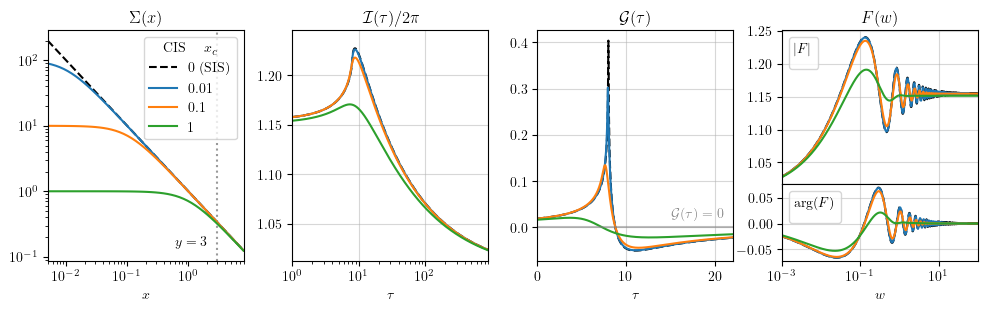

In [6]:
## --- Set up lenses
y = 3
xc_array = [0.01, 0.1, 1]

p_prec = {'tmin':1e-2, \
          'tmax':1e6, \
          'Nt':5000, \
          'sampling':'log'}

p_prec_w = {'fmin' : 1e-3, \
            'fmax' : 1e2, \
            'interp_kind' : 'linear', \
            'N_above_discard' : 2, \
            'N_below_discard' : 3}

dt = 1e-2
deriv = lambda I, t: 0.5*(I.eval_It(t+dt)-I.eval_It(t-dt))/dt

ItSIS = time_domain_c.It_AnalyticSIS_C({'y' : y}, p_prec)
FwSIS = freq_domain_c.Fw_SL(ItSIS, p_prec=p_prec_w)

## --- Set up grid
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(2, 4, figure=fig, wspace=0.25, hspace=0, height_ratios=[2, 1])

ax_S = fig.add_subplot(gs[:, 0])
ax_I = fig.add_subplot(gs[:, 1])
ax_G = fig.add_subplot(gs[:, 2])
ax_F0 = fig.add_subplot(gs[0, 3])
ax_F1 = fig.add_subplot(gs[1, 3])

## -- plot SIS
x = np.geomspace(5e-3, 8, 50)
tau, It = ItSIS.t_grid, ItSIS.It_grid
G = deriv(ItSIS, tau)

ax_S.axvline(y, c='gray', ls=':', alpha=0.8)
ax_S.loglog(x, 1/x, 'k--', label='$0$ (SIS)')
ax_I.plot(tau, It/(2*np.pi), 'k--', label='$0$ (SIS)')
ax_G.plot(tau, G, 'k--')
ax_F0.semilogx(FwSIS.w_grid, np.abs(FwSIS.Fw_grid), 'k--')
ax_F1.semilogx(FwSIS.w_grid, np.angle(FwSIS.Fw_grid), 'k--')

## --- Compute and plot

for i, xc in enumerate(xc_array):
    
    # compute
    Psi = lenses.Psi_CIS({'rc':xc})
    It = time_domain_c.It_SingleContour_C(Psi, {'y':y}, p_prec)
    ts, Its = It.t_grid, It.It_grid
    Gs = deriv(It, ts)
    
    Fw = freq_domain_c.Fw_SL(It, p_prec=p_prec_w)
    ws = np.geomspace(Fw.w_grid[0], Fw.w_grid[-1], 5000)
    Fws = Fw.eval_Fw(ws)
    
    print("(%d/%d) y = %3.2g  ->  computed" % (i+1, len(y_array), y), end='')
    
    # plot
    ax_S.loglog(x, 1/np.sqrt(x**2+xc**2), c='C%i' % i, label='%g' % xc)
    ax_I.plot(ts, Its/(2*np.pi), c='C%i' % i)
    ax_G.plot(ts, Gs, c='C%i' % i)
    ax_F0.plot(ws, np.abs(Fws), c='C%i' % i)
    ax_F1.plot(ws, np.angle(Fws), c='C%i' % i)
    
    print("  ->  plotted")

ax_S.set_title(r'$\Sigma({x})$')
ax_S.set_xlabel('$x$')
ax_S.set_xlim(x.min(), x.max())
ax_S.legend(title=r'CIS $\quad x_c$')
ax_S.annotate(r'$y=%g$' % y, (y/5, 0.15))

ax_I.set_title(r'$\mathcal{I}(\tau)/2\pi$')
ax_I.set_xlabel(r'$\tau$')
ax_I.set_xlim(1, 0.9e3)
ax_I.set_ylim(0.99*np.min(ItSIS.It_grid[ItSIS.t_grid<1e3])/(2*np.pi),1.015*np.max(ItSIS.It_grid)/(2*np.pi))
ax_I.set_xscale('log')
ax_I.grid(alpha=0.5)

ax_G.set_title(r'$\mathcal{G}(\tau)$')
ax_G.set_xlabel(r'$\tau$')
ax_G.set_xlim(0, 22)
ax_G.axhline(0, c='gray', alpha=0.5, label='0')
ax_G.annotate(r'$\mathcal{G}(\tau)=0$', (15, 0.02), c='gray', alpha=0.9)
ax_G.grid(alpha=0.5)

ax_F0.set_title('$F(w)$')
ax_F0.set_xlim(1e-3, 1e2)
ax_F0.tick_params(axis='x', labelbottom=False)
ax_F0.set_xscale('log')
ax_F0.grid(alpha=0.5)
ax_F0.legend(title='$|F|$', loc=2)

ax_F1.set_xlabel('$w$')
ax_F1.set_xlim(1e-3, 1e2)
ax_F1.set_xscale('log')
ax_F1.grid(alpha=0.5)
ax_F1.legend(title="$\\mathrm{arg}(F)$", loc=2)

fig.savefig('plots/CIS_vary_xc.pdf',bbox_inches='tight')
#fig.savefig('plots/CIS_vary_xc.png')

# Comparisons

## SIS

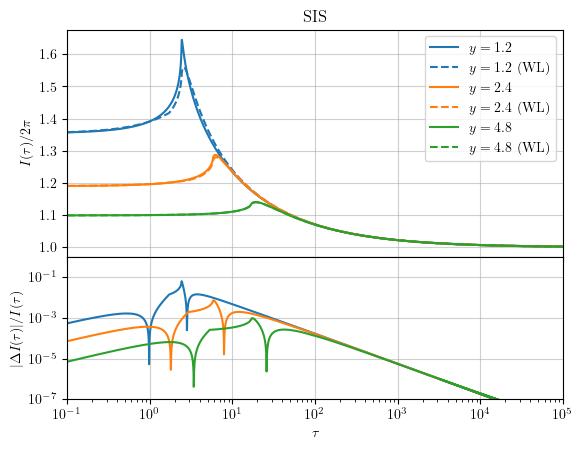

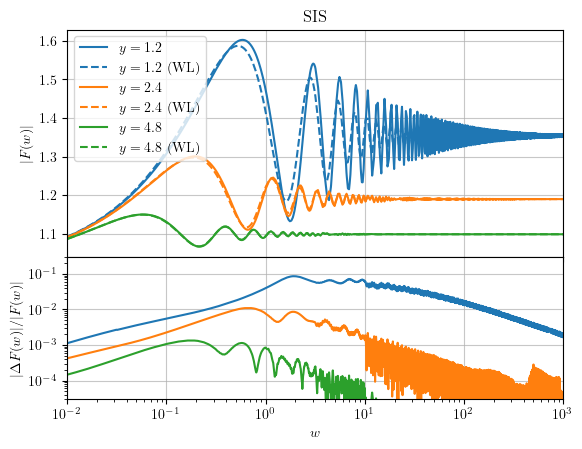

In [7]:
Psi = lenses.Psi_SIS()
(fig1, ax11, ax12), (fig2, ax21, ax22) = compare_lens(Psi)
    
ax22.set_ylim(ymin=3e-5, ymax=3e-1)
fig2.savefig('plots/comparison_Fw_SIS.pdf')

## CIS

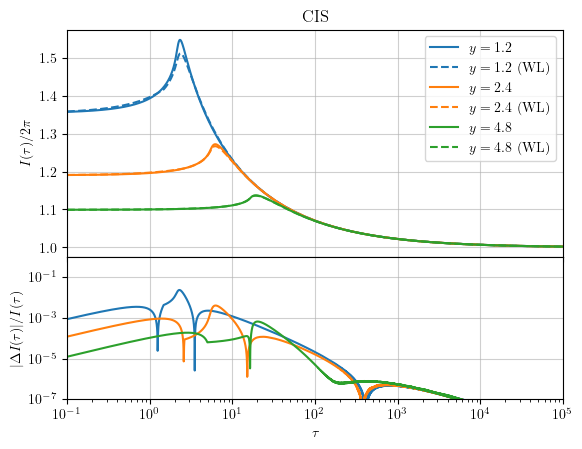

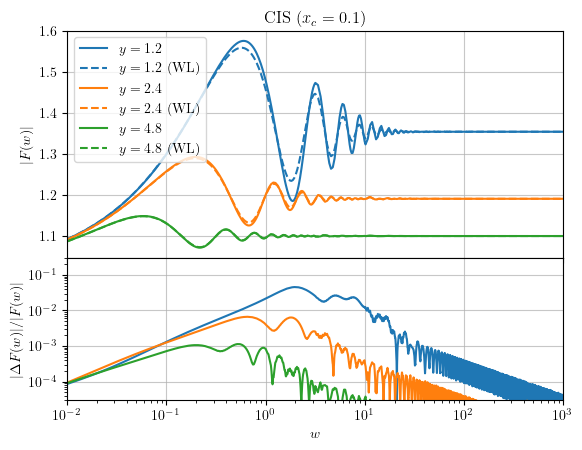

In [8]:
Psi = lenses.Psi_CIS({'rc' : 0.1})
(fig1, ax11, ax12), (fig2, ax21, ax22) = compare_lens(Psi)
    
ax22.set_ylim(ymin=3e-5, ymax=3e-1)
ax21.set_title('CIS ($x_c=%g$)' % Psi.p_phys['rc'])
fig2.savefig('./plots/comparison_Fw_CIS.pdf')

## Composite

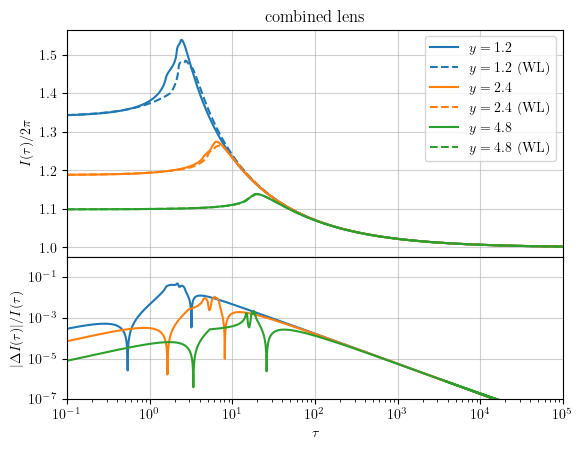

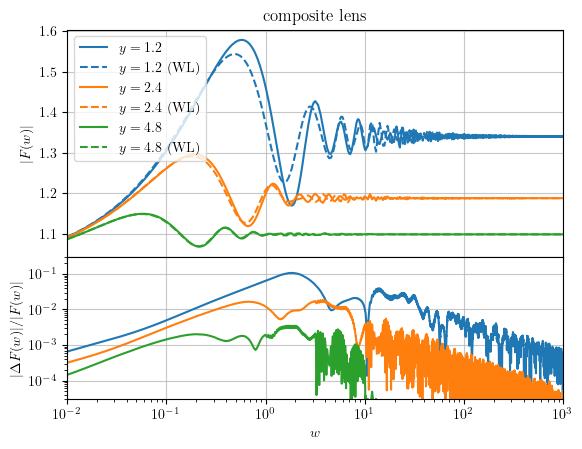

In [9]:
Psi1 = lenses.Psi_offcenterSIS({'psi0':1/3., 'xc1':0.4,  'xc2':-0.5})
Psi2 = lenses.Psi_offcenterSIS({'psi0':1/3., 'xc1':-0.1, 'xc2':-0.3})
Psi3 = lenses.Psi_offcenterSIS({'psi0':1/3., 'xc1':-0.3, 'xc2':0.8})
Psi = lenses.CombinedLens({'lenses':[Psi1, Psi2, Psi3]})
(fig1, ax11, ax12), (fig2, ax21, ax22) = compare_lens(Psi)
    
ax22.set_ylim(ymin=3e-5, ymax=3e-1)
ax21.set_title('composite lens')
fig2.savefig('plots/comparison_Fw_composite.pdf')

# Random realizations

## Individual plots and definitions

Seed: 1861440


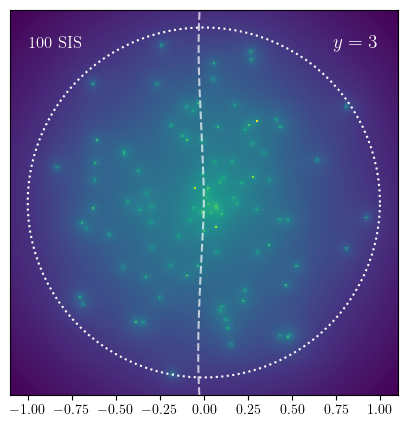

In [3]:
#create lenses
N_sub = 100
R_max = 1
slope = 1
y = 3

xc1s, xc2s, s = distribute_centers(N_sub, slope=slope, R_max=R_max)
Psi = create_composite_lens(xc1s, xc2s)

fig, ax = plt.subplots(figsize=(5,5))
plot_Sigma(ax, xc1s, xc2s, y=y, grid_lim=1.1, circle_radius=1, tauC_contour=True, tauC_psi=Psi)

/home/hector/Documents/gw_lensing/glow_repo/wl_paper/glow/time_domain_c.py:122: TimeDomainWarning: lens 'composite_SIS' not implemented in C, proceeding numerically
  warnings.warn(message, TimeDomainWarning)


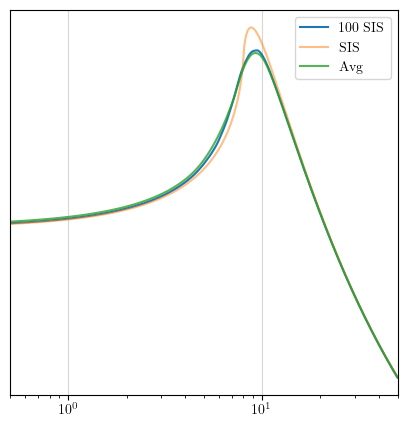

In [4]:
It_results = compute_It(Psi, y=y, CIS=False)
fig, ax = plt.subplots(figsize=(5,5))
plot_It(ax, It_results)

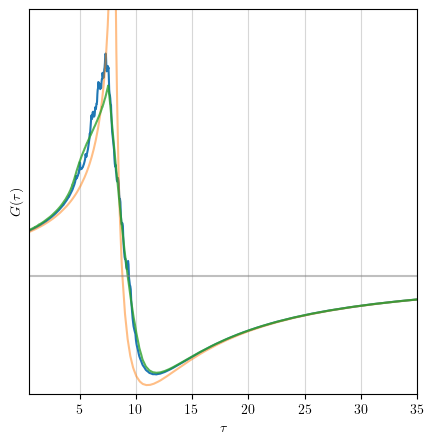

In [5]:
fig,ax = plt.subplots(figsize=(5,5))
plot_Gt(ax, It_results, tau_max=35, labels=True)

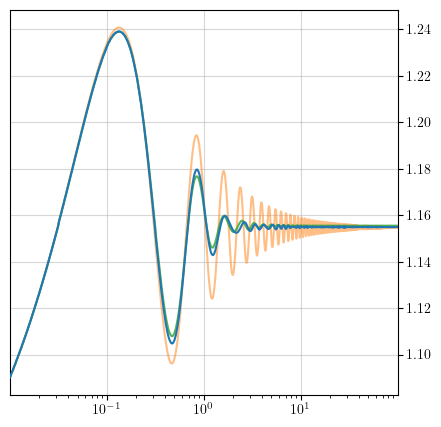

In [6]:
fig,ax = plt.subplots(figsize=(5,5))
plot_Fw(ax, It_results)

Seed: 7090706


/home/hector/Documents/gw_lensing/glow_repo/wl_paper/glow/time_domain_c.py:122: TimeDomainWarning: lens 'composite_SIS' not implemented in C, proceeding numerically
  warnings.warn(message, TimeDomainWarning)


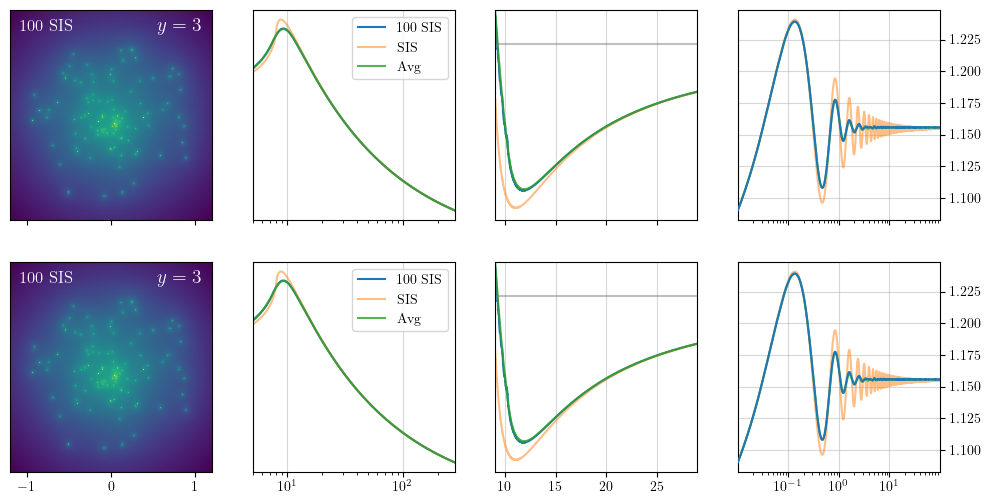

In [7]:
#create lenses
N_sub = 100
R_max = 1
slope = 1
y = 3

xc1s, xc2s, s = distribute_centers(N_sub, slope=slope, R_max=R_max)
Psi = create_composite_lens(xc1s, xc2s)

It_results = compute_It(Psi, y=y, CIS=False)

N_row = 2
fig, ax = plt.subplots(N_row, 4, figsize=(12,3*N_row), sharex='col')
plot_row(ax, 0, xc1s, xc2s, It_results)
plot_row(ax, 1, xc1s, xc2s, It_results)

## Varying number

Seed: 3620400


/home/hector/Documents/gw_lensing/glow_repo/wl_paper/glow/time_domain_c.py:122: TimeDomainWarning: lens 'composite_SIS' not implemented in C, proceeding numerically
  warnings.warn(message, TimeDomainWarning)


Seed: 5247625
Seed: 8260650
Seed: 9212461
Seed: 4574545


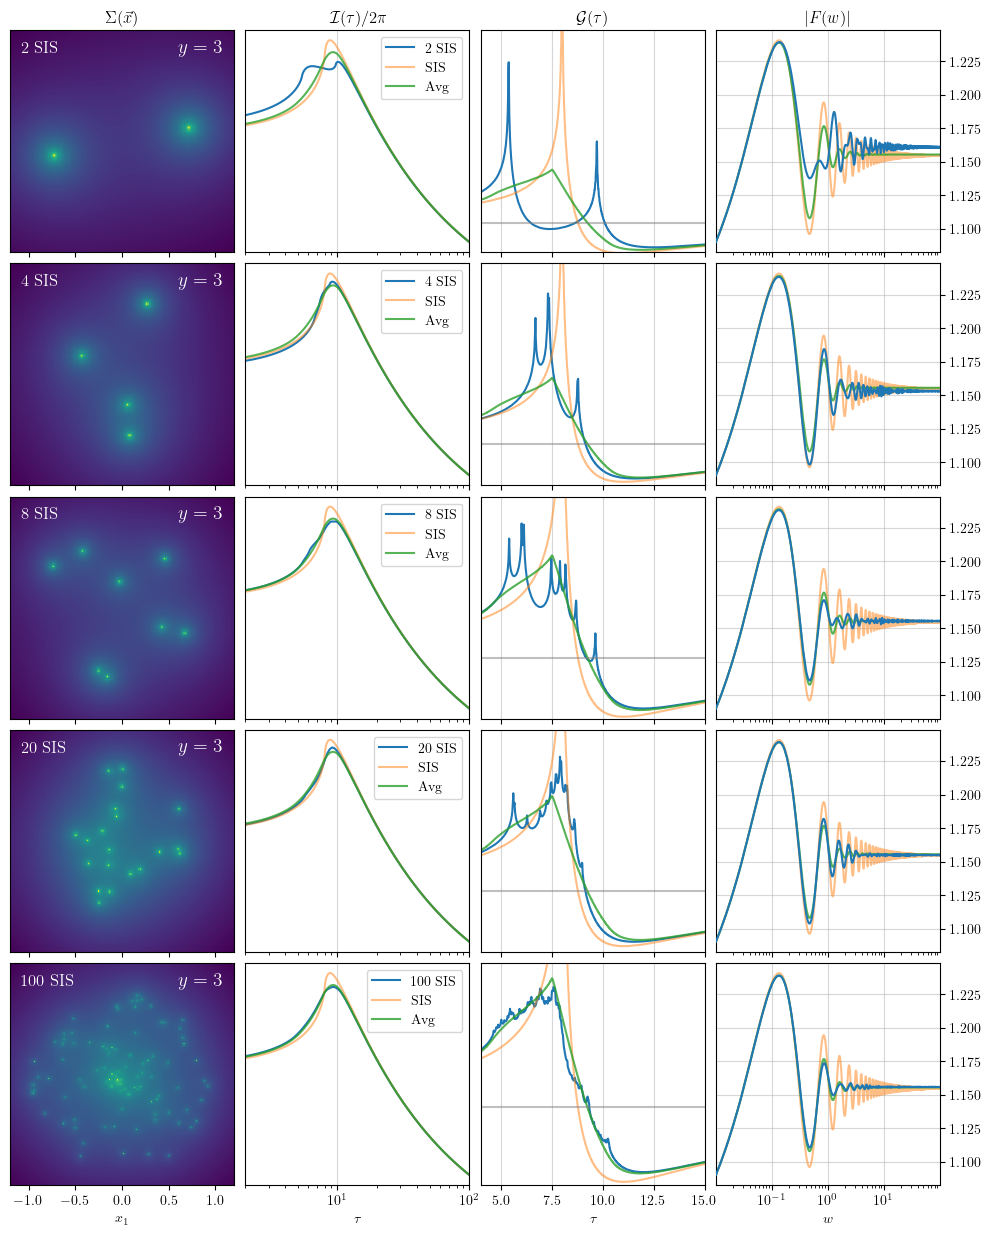

In [8]:
N_sis_arr = [2, 4, 8, 20, 100]
N_row = len(N_sis_arr)

fig, ax = plt.subplots(N_row, 4, figsize=(12, 3*N_row), sharex='col')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

y = 3
for I, N_sub in enumerate(N_sis_arr):
    xc1s , xc2s, s = distribute_centers(N_sub)
    Psi = create_composite_lens(xc1s, xc2s)
    It_results = compute_It(Psi, y)
    plot_row(ax,I,xc1s,xc2s,It_results,tmI=2,tMI=1e2,tmG=4,tMG=15,show_tC_contour=False)

ax[0,0].set_title(r'$\Sigma(\vec x)$')
ax[0,1].set_title(r'$\mathcal{I}(\tau)/2\pi$')
ax[0,2].set_title(r'$\mathcal{G}(\tau)$')
ax[0,3].set_title(r'$|F(w)|$')

ax[N_row-1,0].set_xlabel(r'$x_1$')
ax[N_row-1,1].set_xlabel(r'$\tau$')
ax[N_row-1,2].set_xlabel(r'$\tau$')
ax[N_row-1,3].set_xlabel(r'$w$')

fig.savefig('plots/composite_lens_vary_N_old.pdf', bbox_inches='tight')
#fig.savefig('plots/composite_lens_vary_N.png')

Seed: 4143533


/home/hector/Documents/gw_lensing/glow_repo/wl_paper/glow/time_domain_c.py:122: TimeDomainWarning: lens 'composite_SIS' not implemented in C, proceeding numerically
  warnings.warn(message, TimeDomainWarning)


Seed: 3327274
Seed: 1942153
Seed: 4786032
Seed: 3784717


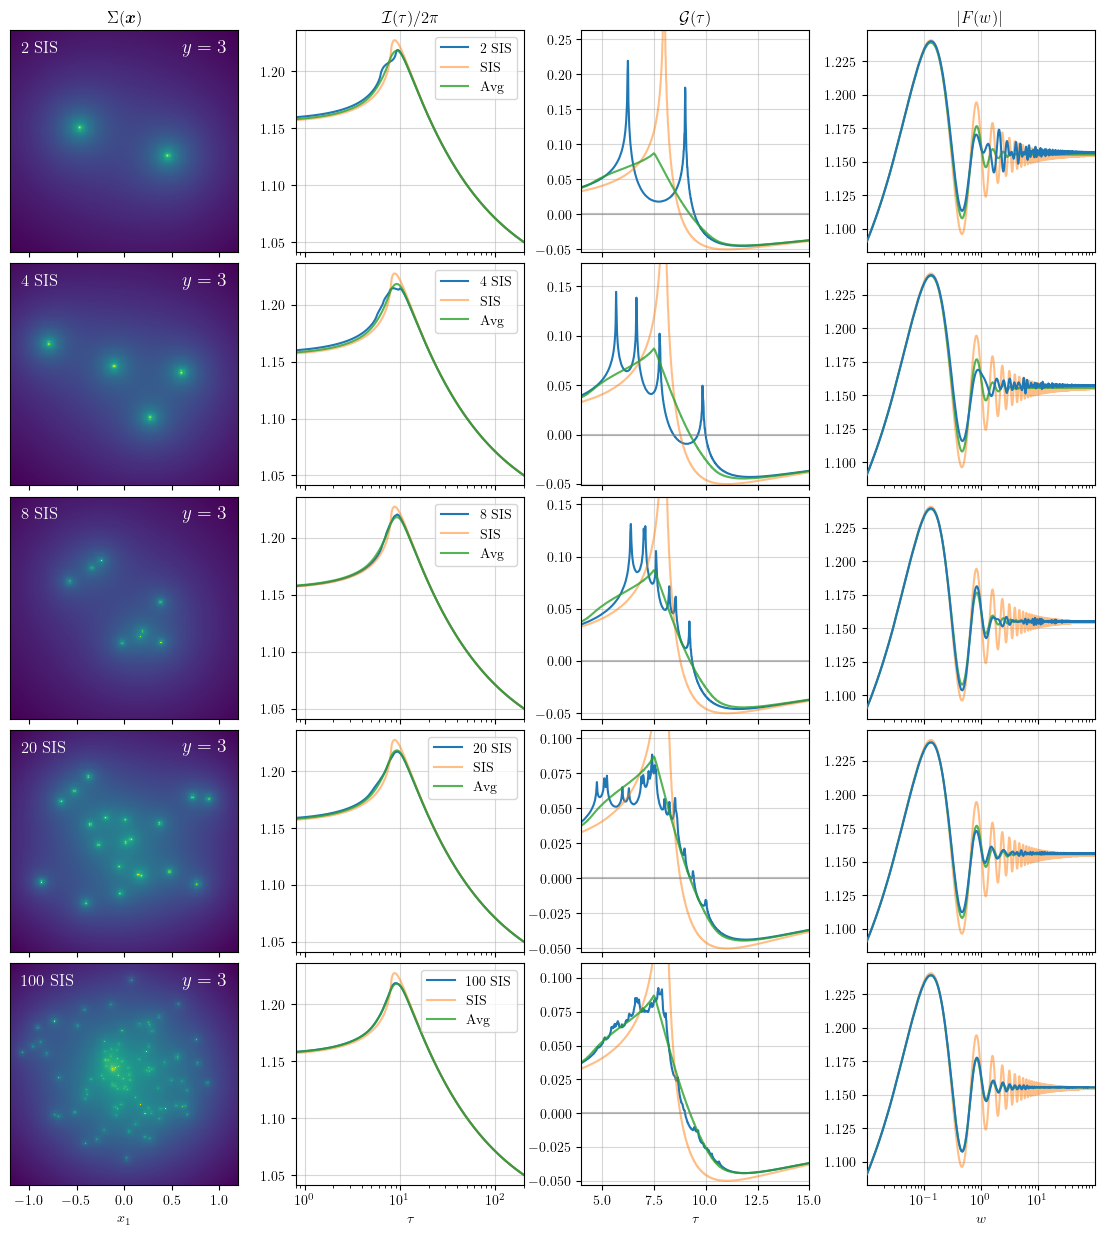

In [9]:
N_sis_arr = [2, 4, 8, 20, 100]
#N_sis_arr = [2, 4]
N_row = len(N_sis_arr)

gridspec_kw = {'hspace' : 0.05, \
               'wspace' : 0.25, \
               'width_ratios' : [1, 1, 1, 1]}

fig, ax = plt.subplots(N_row, 4, figsize=(14, 3*N_row), sharex='col', gridspec_kw=gridspec_kw)

row_kw = {'tmI' : 0.8,\
          'tMI' : 2e2,\
          'tmG' : 4,\
          'tMG' : 15,\
          'show_tC_contour' : False,\
          'yticks' : True,\
          'tick_right' : False}

y = 3
for I, N_sub in enumerate(N_sis_arr):
    xc1s , xc2s, s = distribute_centers(N_sub)
    Psi = create_composite_lens(xc1s, xc2s)
    It_results = compute_It(Psi, y)
    plot_row(ax, I, xc1s, xc2s, It_results, **row_kw)

ax[0,0].set_title(r'$\Sigma(\boldsymbol{x})$')
ax[0,1].set_title(r'$\mathcal{I}(\tau)/2\pi$')
ax[0,2].set_title(r'$\mathcal{G}(\tau)$')
ax[0,3].set_title(r'$|F(w)|$')

ax[N_row-1,0].set_xlabel(r'$x_1$')
ax[N_row-1,1].set_xlabel(r'$\tau$')
ax[N_row-1,2].set_xlabel(r'$\tau$')
ax[N_row-1,3].set_xlabel(r'$w$')

fig.savefig('plots/composite_lens_vary_N.pdf', bbox_inches='tight')
#fig.savefig('plots/composite_lens_vary_N.png')

## Varying y

Seed: 8996892


/home/hector/Documents/gw_lensing/glow_repo/wl_paper/glow/time_domain_c.py:122: TimeDomainWarning: lens 'composite_SIS' not implemented in C, proceeding numerically
  warnings.warn(message, TimeDomainWarning)


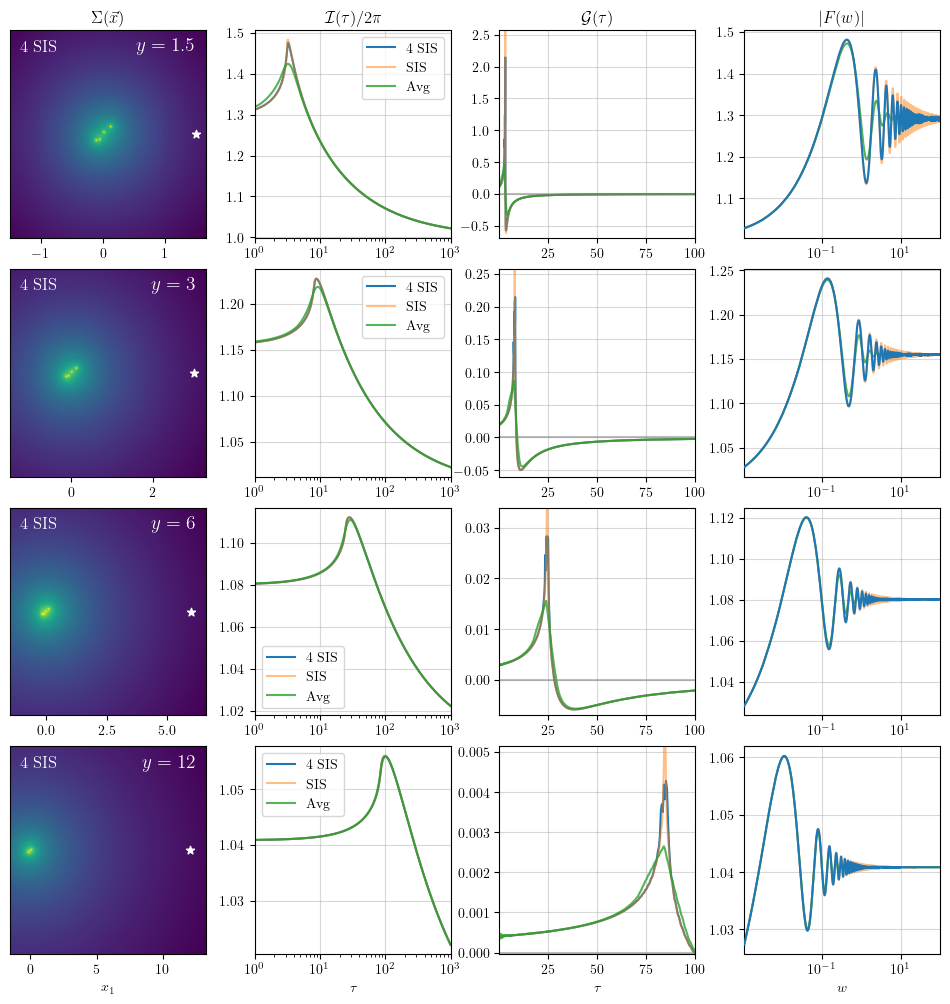

In [10]:
y_arr = [1.5, 3, 6, 12]
N_row = len(y_arr)

N_sub = 4

fig, ax = plt.subplots(N_row,4,figsize=(12,3*N_row))#,sharey='col')
plt.subplots_adjust(wspace=0.25,hspace=0.15)

xc1s, xc2s, s = distribute_centers(N_sub)
Psi = create_composite_lens(xc1s, xc2s)

for I, y in enumerate(y_arr):
    It_results = compute_It(Psi,y)
    plot_row(ax,I,xc1s,xc2s,It_results,tmI=1,tMI=1e3,tmG=0.2,tMG=100,wmF=1e-3,yticks=True,tick_right=False,show_source=True,show_tC_contour=False)

ax[0,0].set_title(r'$\Sigma(\vec x)$')
ax[0,1].set_title(r'$\mathcal{I}(\tau)/2\pi$')
ax[0,2].set_title(r'$\mathcal{G}(\tau)$')
ax[0,3].set_title(r'$|F(w)|$')

ax[N_row-1,0].set_xlabel(r'$x_1$')
ax[N_row-1,1].set_xlabel(r'$\tau$')
ax[N_row-1,2].set_xlabel(r'$\tau$')
ax[N_row-1,3].set_xlabel(r'$w$')

fig.savefig('plots/composite_lens_vary_y.pdf', bbox_inches='tight')
#fig.savefig('plots/composite_lens_vary_y.png')

## Varying realization

Seed: 446200


/home/hector/Documents/gw_lensing/glow_repo/wl_paper/glow/time_domain_c.py:122: TimeDomainWarning: lens 'composite_SIS' not implemented in C, proceeding numerically
  warnings.warn(message, TimeDomainWarning)


Seed: 7587636
Seed: 8767879


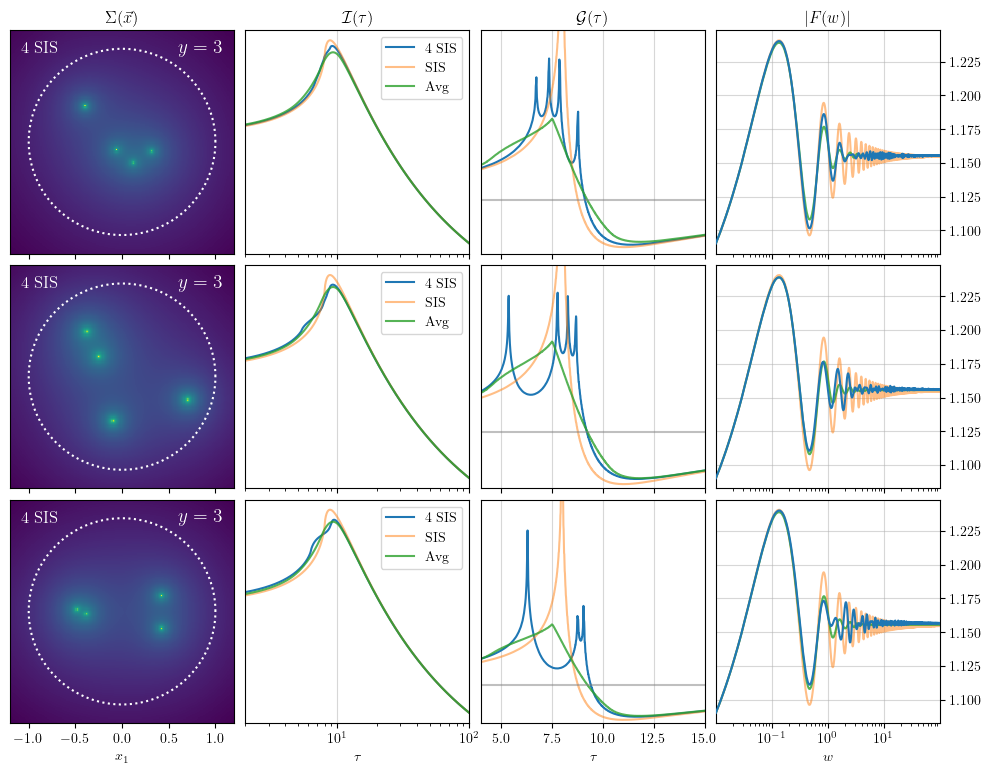

In [11]:
y = 3
N_sub = 4

y_arr = y*np.ones(3)
N_row = len(y_arr)

fig, ax = plt.subplots(N_row,4,figsize=(12,3*N_row),sharex='col')
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for I, y in enumerate(y_arr):
    xc1s,xc2s,s = distribute_centers(N_sub)
    Psi = create_composite_lens(xc1s,xc2s)
    It_results = compute_It(Psi,y)
    plot_row(ax,I,xc1s,xc2s, It_results, show_lens_lim=True, tmI=2,tMI=1e2,tmG=4,tMG=15,show_tC_contour=False)

ax[0,0].set_title(r'$\Sigma(\vec x)$')
ax[0,1].set_title(r'$\mathcal{I}(\tau)$')
ax[0,2].set_title(r'$\mathcal{G}(\tau)$')
ax[0,3].set_title(r'$|F(w)|$')

ax[N_row-1,0].set_xlabel(r'$x_1$')
ax[N_row-1,1].set_xlabel(r'$\tau$')
ax[N_row-1,2].set_xlabel(r'$\tau$')
ax[N_row-1,3].set_xlabel(r'$w$')

plt.savefig('plots/composite_lens_vary_realization_old.pdf', bbox_inches='tight')
#plt.savefig('plots/composite_lens_vary_realization_old.png')

Seed: 3327169


/home/hector/Documents/gw_lensing/glow_repo/wl_paper/glow/time_domain_c.py:122: TimeDomainWarning: lens 'composite_SIS' not implemented in C, proceeding numerically
  warnings.warn(message, TimeDomainWarning)


Seed: 1516059
Seed: 5212889
Seed: 4061586


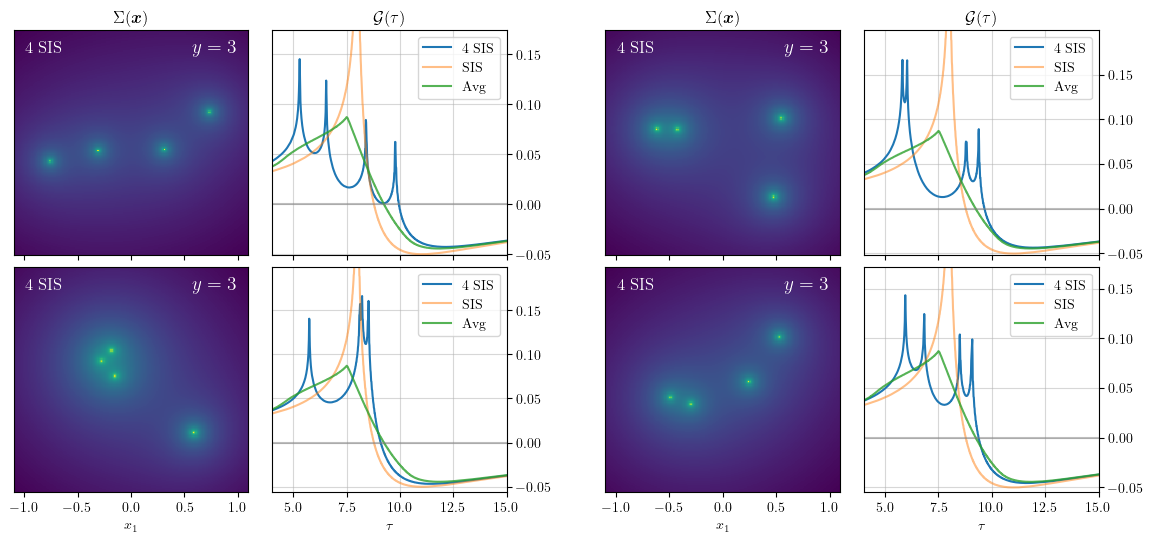

In [12]:
## --- Set up lens
y = 3
N_sub = 4

Sigma_kwargs = {'y' : y, 
                'grid_lim' : 1.1, \
                'circle_radius' : 0, \
                'tauC_contour' : False}

Gt_kwargs    = {'yticks' : True, 
                'legend' : True, \
                'tau_min' : 4, \
                'tau_max' : 15}

## ---------------------------------------------------------------

## --- Set up grid
Nrows = 2

fig = plt.figure(figsize=(14, 3*Nrows))

subgrid_kw = {'hspace' : 0.05, \
              'wspace' : 0.1, \
              'width_ratios' : [1, 1], \
              'height_ratios' : [1 for i in range(Nrows)]}

gs0 = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.2)
gs00 = gs0[0].subgridspec(Nrows, 2, **subgrid_kw)
gs01 = gs0[1].subgridspec(Nrows, 2, **subgrid_kw)

gs = [g for g in gs00] + [g for g in gs01]

sigma_axes = [fig.add_subplot(g) for g in gs[::2]]
Gt_axes    = [fig.add_subplot(g) for g in gs[1::2]]

## -------------------------------------------------------------

for i, (ax1, ax2) in enumerate(zip(sigma_axes, Gt_axes)):
    
    xc1s, xc2s, s = distribute_centers(N_sub)
    Psi = create_composite_lens(xc1s, xc2s)
    It_results = compute_It(Psi, y)
    
    Sigma_kwargs['tauC_psi'] = Psi
    plot_Sigma(ax1, xc1s, xc2s, **Sigma_kwargs)
    plot_Gt(ax2, It_results, **Gt_kwargs)
    
    ax2.yaxis.tick_right()
    
    if (i == 0) or (i == Nrows):
        ax1.set_title(r'$\Sigma(\boldsymbol{x})$')
        ax2.set_title(r'$\mathcal{G}(\tau)$')
    
    # keep the labels in the lowest row
    if (i == Nrows-1) or (i == 2*Nrows-1):
        ax1.set_xlabel('$x_1$')
        ax2.set_xlabel('$\\tau$')
        continue
    
    ax1.tick_params(axis='x', labelbottom=False)
    ax2.tick_params(axis='x', labelbottom=False)
    
fig.savefig('plots/composite_lens_vary_realization.pdf', bbox_inches='tight')
#fig.savefig('plots/composite_lens_vary_realization.png')

## Line of lenses

(1/4) theta = 0
(2/4) theta = 0.523599
(3/4) theta = 1.0472
(4/4) theta = 1.5708


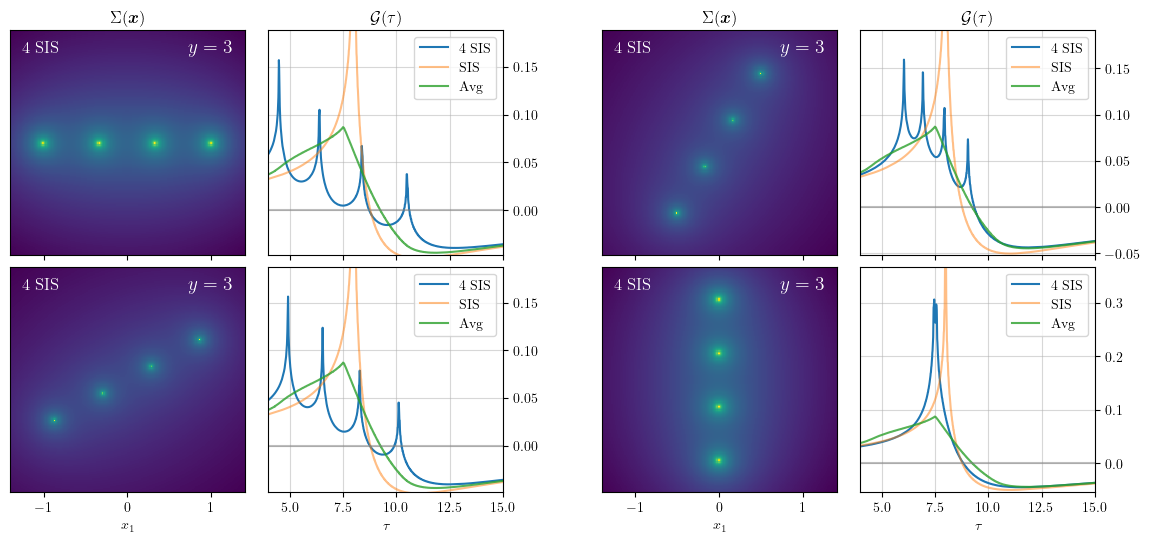

In [13]:
## --- Distribute lenses in a line
def distribute_line(n, theta, rmax=1):
    
    x0s = np.linspace(-rmax, rmax, num=n)
    
    # rotate
    x1s = x0s*np.cos(theta)
    x2s = x0s*np.sin(theta)
    
    return x1s, x2s
## -------------------------------------------------

## --- Set up lens
y = 3
N_sub = 4

thetas = np.linspace(0, 0.5*np.pi, num=4)

Sigma_kwargs = {'y' : y, 
                'grid_lim' : 1.4, \
                'circle_radius' : 0, \
                'tauC_contour' : False}

Gt_kwargs    = {'yticks' : True, 
                'legend' : True, \
                'tau_min' : 4, \
                'tau_max' : 15}

## ---------------------------------------------------------------

## --- Set up grid
Nrows = int(np.ceil(len(thetas)/2.))

fig = plt.figure(figsize=(14, 3*Nrows))

subgrid_kw = {'hspace' : 0.05, \
              'wspace' : 0.1, \
              'width_ratios' : [1, 1], \
              'height_ratios' : [1 for i in range(Nrows)]}

gs0 = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.2)
gs00 = gs0[0].subgridspec(Nrows, 2, **subgrid_kw)
gs01 = gs0[1].subgridspec(Nrows, 2, **subgrid_kw)

gs = [g for g in gs00] + [g for g in gs01]

sigma_axes = [fig.add_subplot(g) for g in gs[::2]]
Gt_axes    = [fig.add_subplot(g) for g in gs[1::2]]

## -------------------------------------------------------------

for i, (ax1, ax2) in enumerate(zip(sigma_axes, Gt_axes)):
    
    xc1s, xc2s = distribute_line(N_sub, thetas[i])
    Psi = create_composite_lens(xc1s, xc2s)
    It_results = compute_It(Psi, y)
    
    Sigma_kwargs['tauC_psi'] = Psi
    plot_Sigma(ax1, xc1s, xc2s, **Sigma_kwargs)
    plot_Gt(ax2, It_results, **Gt_kwargs)
    
    # track progress
    print('(%d/%d) theta = %g' % (i+1, len(thetas), thetas[i]))
    
    ax2.yaxis.tick_right()
    
    if (i == 0) or (i == Nrows):
        ax1.set_title(r'$\Sigma(\boldsymbol{x})$')
        ax2.set_title(r'$\mathcal{G}(\tau)$')
    
    # keep the labels in the lowest row
    if (i == Nrows-1) or (i == 2*Nrows-1):
        ax1.set_xlabel('$x_1$')
        ax2.set_xlabel('$\\tau$')
        continue
    
    ax1.tick_params(axis='x', labelbottom=False)
    ax2.tick_params(axis='x', labelbottom=False)
    
fig.savefig('plots/composite_lens_line.pdf', bbox_inches='tight')
#fig.savefig('plots/composite_lens_line.png')

# Talk plots (in progress)

Seed: 4896105
Seed: 441081


Text(0.5, 0, '$w$')

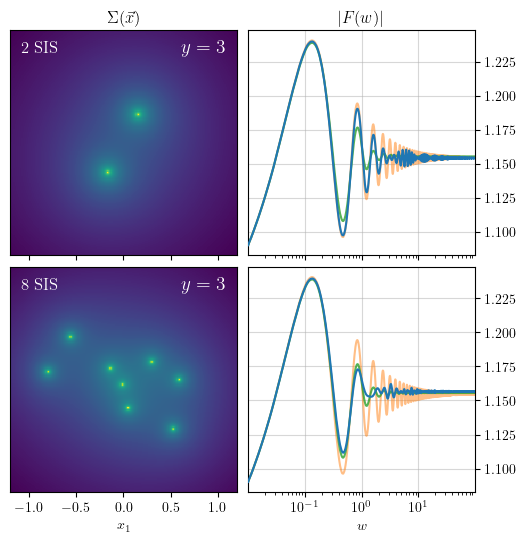

In [14]:
plot_items = ['S','F']

N_sis_arr = [2,8]
N_row = len(N_sis_arr)
N_items = len(plot_items)

fig, ax = plt.subplots(N_row, N_items, figsize=(3*N_items, 3*N_row), sharex='col')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

y = 3
for I, N_sub in enumerate(N_sis_arr):
    xc1s , xc2s, s = distribute_centers(N_sub)
    Psi = create_composite_lens(xc1s, xc2s)
    It_results = compute_It(Psi, y)
    plot_row_custom(ax,I,xc1s,xc2s,It_results,plot_items=plot_items, tmI=2,tMI=1e2,tmG=4,tMG=15,show_tC_contour=False)

ax[0,0].set_title(r'$\Sigma(\vec x)$')
# ax[0,1].set_title(r'$\mathcal{I}(\tau)/2\pi$')
# ax[0,2].set_title(r'$\mathcal{G}(\tau)$')
ax[0,1].set_title(r'$|F(w)|$')

ax[N_row-1,0].set_xlabel(r'$x_1$')
# ax[N_row-1,1].set_xlabel(r'$\tau$')
# ax[N_row-1,2].set_xlabel(r'$\tau$')
ax[N_row-1,1].set_xlabel(r'$w$')

# fig.savefig('plots/talks/composite_lens_vary_N_0.pdf', bbox_inches='tight')
# fig.savefig('plots/talks/composite_lens_vary_N_0.png')

Seed: 3948944
Seed: 7524955


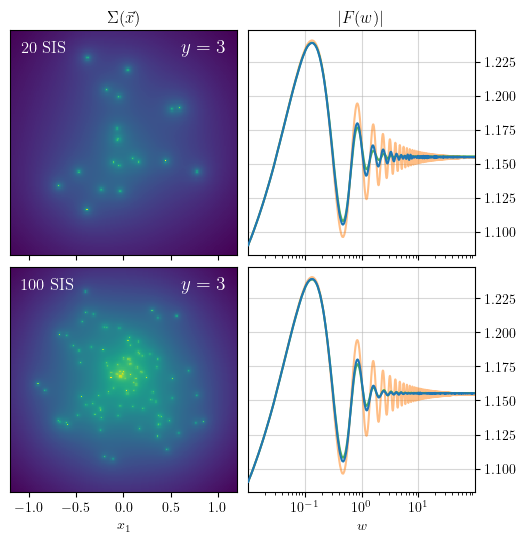

In [15]:
plot_items = ['S','F']

N_sis_arr = [20,100]
N_row = len(N_sis_arr)
N_items = len(plot_items)

fig, ax = plt.subplots(N_row, N_items, figsize=(3*N_items, 3*N_row), sharex='col')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

y = 3
for I, N_sub in enumerate(N_sis_arr):
    xc1s , xc2s, s = distribute_centers(N_sub)
    Psi = create_composite_lens(xc1s, xc2s)
    It_results = compute_It(Psi, y)
    plot_row_custom(ax,I,xc1s,xc2s,It_results,plot_items=plot_items, tmI=2,tMI=1e2,tmG=4,tMG=15,show_tC_contour=False)

ax[0,0].set_title(r'$\Sigma(\vec x)$')
# ax[0,1].set_title(r'$\mathcal{I}(\tau)/2\pi$')
# ax[0,2].set_title(r'$\mathcal{G}(\tau)$')
ax[0,1].set_title(r'$|F(w)|$')

ax[N_row-1,0].set_xlabel(r'$x_1$')
# ax[N_row-1,1].set_xlabel(r'$\tau$')
# ax[N_row-1,2].set_xlabel(r'$\tau$')
ax[N_row-1,1].set_xlabel(r'$w$')

fig.savefig('plots/talks/composite_lens_vary_N_1.pdf', bbox_inches='tight')
fig.savefig('plots/talks/composite_lens_vary_N_1.png')

Seed: 927195
Seed: 2683391


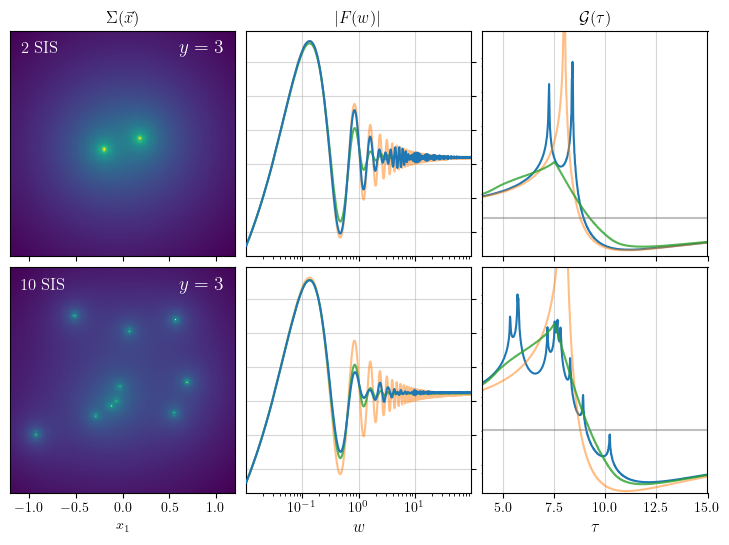

In [16]:
plot_items = ['S','F','G']

N_sis_arr = [2,10]
N_row = len(N_sis_arr)
N_items = len(plot_items)

fig, ax = plt.subplots(N_row, N_items, figsize=(3*N_items, 3*N_row), sharex='col')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

y = 3
for I, N_sub in enumerate(N_sis_arr):
    xc1s , xc2s, s = distribute_centers(N_sub)
    Psi = create_composite_lens(xc1s, xc2s)
    It_results = compute_It(Psi, y)
    plot_row_custom(ax,I,xc1s,xc2s,It_results,plot_items=plot_items, tmI=2,tMI=1e2,tmG=4,tMG=15,show_tC_contour=False)

ax[0,0].set_title(r'$\Sigma(\vec x)$',fontsize=12)
# ax[0,1].set_title(r'$\mathcal{I}(\tau)/2\pi$')
ax[0,2].set_title(r'$\mathcal{G}(\tau)$',fontsize=12)
ax[0,1].set_title(r'$|F(w)|$',fontsize=12)

ax[N_row-1,0].set_xlabel(r'$x_1$')
# ax[N_row-1,1].set_xlabel(r'$\tau$')
ax[N_row-1,2].set_xlabel(r'$\tau$',fontsize=12)
ax[N_row-1,1].set_xlabel(r'$w$',fontsize=12)

fig.savefig('plots/talks/composite_lens_vary_N_0.pdf', bbox_inches='tight',facecolor='w')
fig.savefig('plots/talks/composite_lens_vary_N_0.png', bbox_inches='tight',facecolor='w')

Seed: 6372724


/home/hector/Documents/gw_lensing/glow_repo/wl_paper/glow/time_domain_c.py:122: TimeDomainWarning: lens 'composite_SIS' not implemented in C, proceeding numerically
  warnings.warn(message, TimeDomainWarning)


Seed: 660374


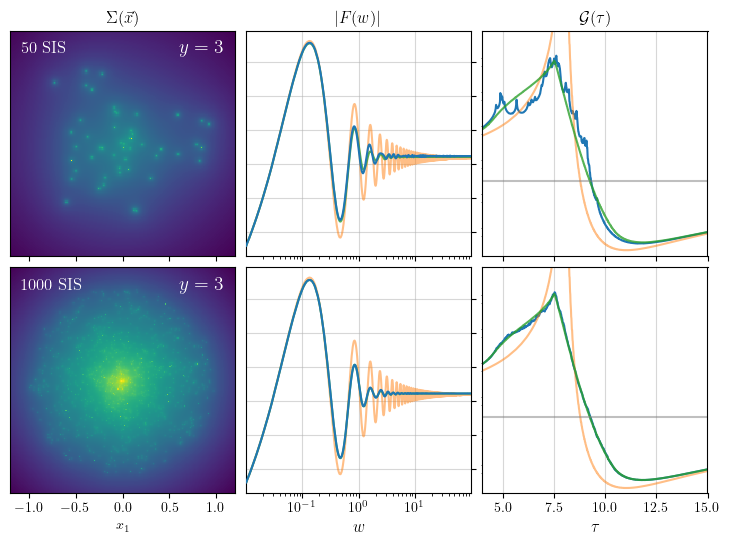

In [17]:
plot_items = ['S','F','G']

N_sis_arr = [50,1000]
N_row = len(N_sis_arr)
N_items = len(plot_items)

fig, ax = plt.subplots(N_row, N_items, figsize=(3*N_items, 3*N_row), sharex='col')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

y = 3
for I, N_sub in enumerate(N_sis_arr):
    xc1s , xc2s, s = distribute_centers(N_sub)
    Psi = create_composite_lens(xc1s, xc2s)
    It_results = compute_It(Psi, y)
    plot_row_custom(ax,I,xc1s,xc2s,It_results,plot_items=plot_items, tmI=2,tMI=1e2,tmG=4,tMG=15,show_tC_contour=False)

ax[0,0].set_title(r'$\Sigma(\vec x)$',fontsize=12)
# ax[0,1].set_title(r'$\mathcal{I}(\tau)/2\pi$')
ax[0,2].set_title(r'$\mathcal{G}(\tau)$',fontsize=12)
ax[0,1].set_title(r'$|F(w)|$',fontsize=12)

ax[N_row-1,0].set_xlabel(r'$x_1$')
# ax[N_row-1,1].set_xlabel(r'$\tau$')
ax[N_row-1,2].set_xlabel(r'$\tau$',fontsize=12)
ax[N_row-1,1].set_xlabel(r'$w$',fontsize=12)

fig.savefig('plots/talks/composite_lens_vary_N_1.pdf', bbox_inches='tight',facecolor='w')
fig.savefig('plots/talks/composite_lens_vary_N_1.png', bbox_inches='tight',facecolor='w')

contour plotted


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1/4) y = 1.5  ->  computed  ->  plotted


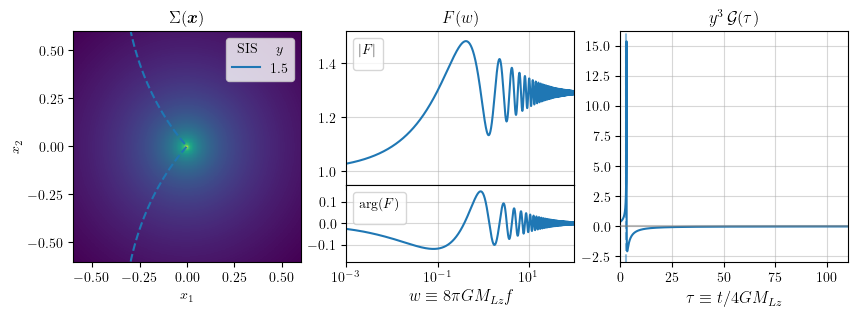

contour plotted
(1/4) y = 1.5  ->  computed

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2/4) y =   3  ->  computed  ->  plotted


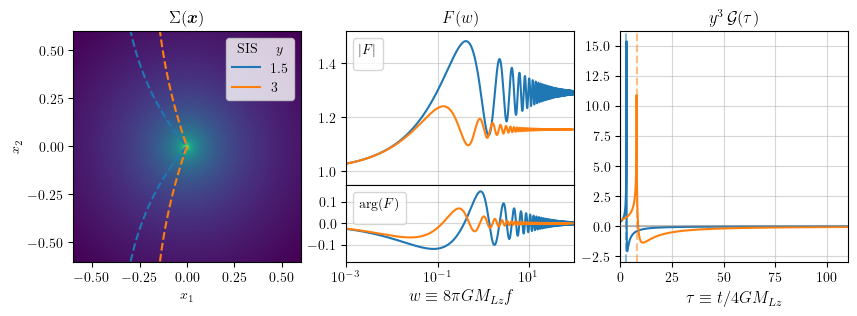

contour plotted
(1/4) y = 1.5  ->  computed(2/4) y =   3  ->  computed

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3/4) y =   6  ->  computed  ->  plotted


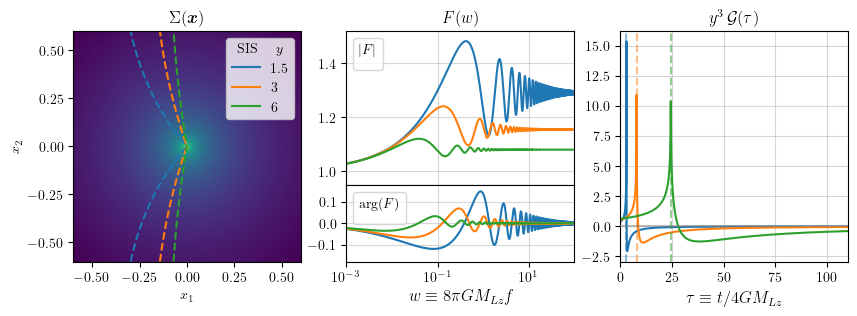

contour plotted
(1/4) y = 1.5  ->  computed(2/4) y =   3  ->  computed(3/4) y =   6  ->  computed

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(4/4) y =  12  ->  computed  ->  plotted


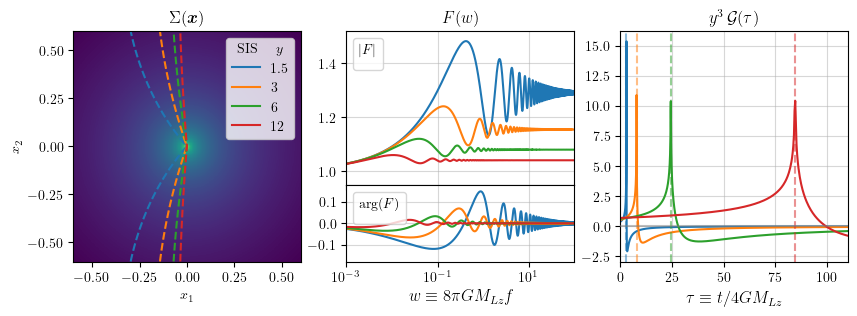

In [19]:
## --- Set up lenses
y_array = [1.5, 3, 6, 12]

p_prec = {'tmin':1e-2, \
          'tmax':1e6, \
          'Nt':5000, \
          'sampling':'log'}

p_prec_w = {'fmin' : 1e-3, \
            'fmax' : 1e2, \
            'interp_kind' : 'linear', \
            'N_above_discard' : 2, \
            'N_below_discard' : 3}

for j, y in enumerate(y_array):

    Psi = lenses.Psi_SIS()

    dt = 1e-2
    deriv = lambda I, t: 0.5*(I.eval_It(t+dt)-I.eval_It(t-dt))/dt

    ## --- Set up contour
    Ngrid = 400
    eps_soften = 0.1
    grid_lim = 0.6
    y_plt = 0
    eps = eps_soften/Ngrid

    center, width = (max(grid_lim,y_plt*1.1) - grid_lim)/2, (max(grid_lim,y_plt*1.1) + grid_lim)/2
    y_grid = np.linspace(-width, width, Ngrid)
    x_grid = np.linspace(-width, width, Ngrid) + center

    X, Y = np.meshgrid(x_grid,y_grid)
    R = np.sqrt(X**2 + Y**2)

    Sigma_SIS = 1/np.sqrt(R**2+eps**2)   #normalization is ad-hoc

    ## --- Set up grid
    fig = plt.figure(figsize=(10, 3))
    gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0, height_ratios=[2, 1])

    ax_S = fig.add_subplot(gs[:, 0])
    # ax_I = fig.add_subplot(gs[:, 1])
    ax_G = fig.add_subplot(gs[:, 2])
    ax_F0 = fig.add_subplot(gs[0, 1])
    ax_F1 = fig.add_subplot(gs[1, 1])

    ## --- Compute and plot
    ax_S.pcolor(X, Y, Sigma_SIS, norm=colors.LogNorm(vmin=Sigma_SIS.min(), vmax=Sigma_SIS.max()),rasterized=True)
    print('contour plotted')

    for i, y in enumerate(y_array):
        if i>j:
            continue
        # compute
        It = time_domain_c.It_AnalyticSIS_C({'y':y}, p_prec)
        ts, Its = It.t_grid, It.It_grid
        Gs = deriv(It, ts)

        Fw = freq_domain_c.Fw_SL(It, p_prec=p_prec_w)
        ws = np.geomspace(Fw.w_grid[0], Fw.w_grid[-1], 5000)
        Fws = Fw.eval_Fw(ws)

        PhiC = Psi.phi_Fermat(0, 0, y) - It.tmin
        Phi = Psi.phi_Fermat(X, Y, y) - It.tmin

        print("(%d/%d) y = %3.2g  ->  computed" % (i+1, len(y_array), y), end='')

        # plot
        ax_S.contour(X, Y, Phi,\
                     [Psi.phi_Fermat(0, 0, y) - It.tmin],\
                     colors = 'C%i' % i,\
                     linestyles = 'dashed')
    #     ax_I.plot(ts, Its/(2*np.pi), c='C%i' % i, label='%g' % y)
    #     ax_I.axvline(PhiC, c='C%i' % i, ls='--', alpha=0.5)
        ax_S.plot([], c='C%i' % i,label='%g' % y)
        ax_G.plot(ts, y**3*Gs, c='C%i' % i)
        ax_G.axvline(PhiC, c='C%i' % i, ls='--', alpha=0.5)
        ax_F0.plot(ws, np.abs(Fws), c='C%i' % i)
        ax_F1.plot(ws, np.angle(Fws), c='C%i' % i)
    
    print("  ->  plotted")

    ax_S.set_title(r'$\Sigma(\boldsymbol{x})$',fontsize=12)
    ax_S.set_xlabel('$x_1$')
    ax_S.set_ylabel('$x_2$')
    ax_S.set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax_S.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax_S.legend(title=r'SIS $\quad y$',loc='upper right')

    # ax_I.set_title(r'$\mathcal{I}(\tau)/2\pi$')
    # ax_I.legend(title=r'SIS $\quad y$')
    # ax_I.set_xlabel(r'$\tau$')
    # ax_I.set_xlim(1,.9e3)
    # ax_I.set_xscale('log')
    # ax_I.grid(alpha=0.5)

    ax_G.set_title(r'$y^3\,\mathcal{G}(\tau)$',fontsize=12)
    ax_G.set_xlabel(r'$\tau \equiv t/4GM_{Lz}$',fontsize=12)
    ax_G.set_xlim(0, 110)
    ax_G.axhline(0, c='gray', alpha=0.5, label='0', zorder=10)
    ax_G.grid(alpha=0.5)

    ax_F0.set_title('$F(w)$',fontsize=12)
    ax_F0.set_xlim(1e-3, 1e2)
    ax_F0.set_ylim(0.95, 1.52)
    ax_F0.tick_params(axis='x', labelbottom=False)
    ax_F0.set_xscale('log')
    ax_F0.grid(alpha=0.5)
    ax_F0.legend(title='$|F|$', loc=2)

    ax_F1.set_xlabel('$w\equiv 8\pi G M_{Lz} f$',fontsize=12)
    ax_F1.set_xlim(1e-3, 1e2)
    ax_F1.set_ylim(-0.18, 0.18)
    ax_F1.set_xscale('log')
    ax_F1.grid(alpha=0.5)
    ax_F1.legend(title="$\\mathrm{arg}(F)$", loc=2)
    
    plt.savefig('plots/talks/SIS_vary_y_talk_%i.pdf'%j,bbox_inches='tight',facecolor='w')
    plt.savefig('plots/talks/SIS_vary_y_talk_%i.png'%j,bbox_inches='tight',facecolor='w')
    plt.show()
    plt.close()